### (一) 針對員工離職率 (left) 進行離職與否的預測

In [119]:
import pandas as pd

hr_df = pd.read_csv('HW2_hr-analytics_train.csv')
hr_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     10000 non-null  float64
 1   last_evaluation        10000 non-null  float64
 2   number_project         10000 non-null  int64  
 3   average_montly_hours   10000 non-null  int64  
 4   time_spend_company     10000 non-null  int64  
 5   Work_accident          10000 non-null  int64  
 6   promotion_last_5years  10000 non-null  int64  
 7   sales                  10000 non-null  object 
 8   salary                 10000 non-null  object 
 9   left                   10000 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


#####  sales 欄位跟 salary 欄位不是數字的資料形態且沒有缺失值

#### 對非數字類型的編碼
- sales 用 one-hot encoding
- salary 用 ordinal encoding

In [120]:
from sklearn.preprocessing import OrdinalEncoder

## sales encode
encode = pd.get_dummies(hr_df.sales)

hr_df.drop(['sales'], axis=1, inplace=True)
hr_df = hr_df.join(encode)

## salary encode
categories_order = [['low', 'medium', 'high']]
ordinal_encoder = OrdinalEncoder(categories=categories_order)

# Fit and transform the 'salary' column
hr_df['salary'] = ordinal_encoder.fit_transform(hr_df[['salary']])


hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     10000 non-null  float64
 1   last_evaluation        10000 non-null  float64
 2   number_project         10000 non-null  int64  
 3   average_montly_hours   10000 non-null  int64  
 4   time_spend_company     10000 non-null  int64  
 5   Work_accident          10000 non-null  int64  
 6   promotion_last_5years  10000 non-null  int64  
 7   salary                 10000 non-null  float64
 8   left                   10000 non-null  int64  
 9   IT                     10000 non-null  uint8  
 10  RandD                  10000 non-null  uint8  
 11  accounting             10000 non-null  uint8  
 12  hr                     10000 non-null  uint8  
 13  management             10000 non-null  uint8  
 14  marketing              10000 non-null  uint8  
 15  pro

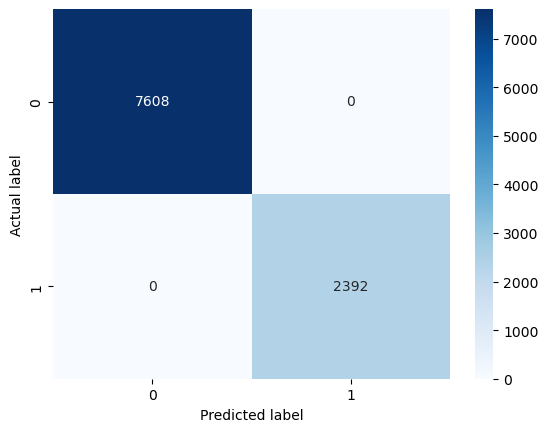

In [122]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

X_train = hr_df.drop(['left'],axis=1)
y_train = hr_df['left']

dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

train_pred = dt.predict(X_train)

c_matrix = confusion_matrix(y_train,train_pred)
tn, fp, fn, tp = c_matrix.ravel()
# print(tn,fp,fn,tp)
# print("acc:",accuracy_score(y_train,train_pred))
# print("f1:",f1_score(y_train,train_pred))



sns.heatmap(c_matrix,annot=True,cmap='Blues',fmt='.20g')

plt.xlabel("Predicted label")
plt.ylabel("Actual label")

plt.show()

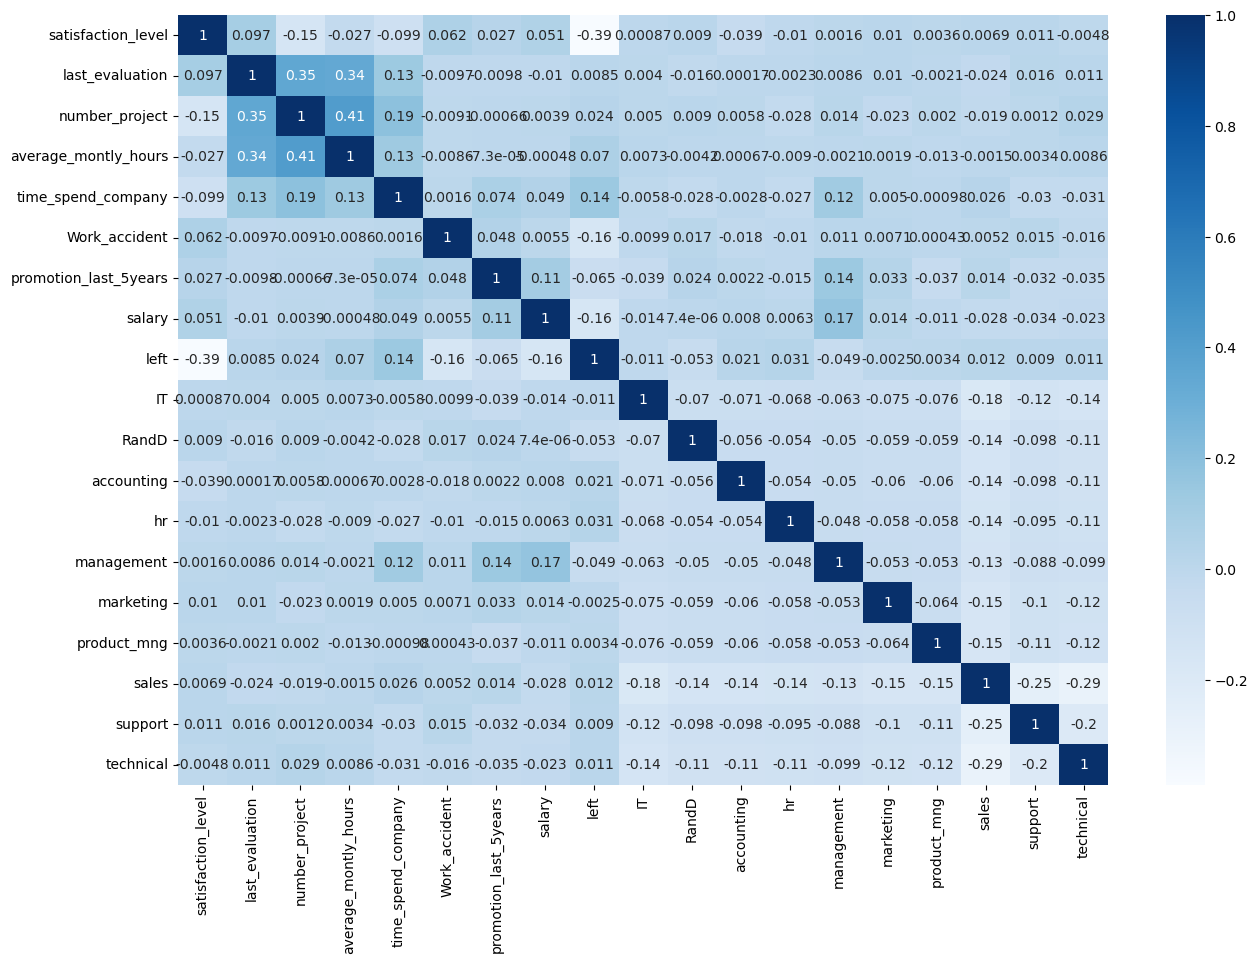

In [123]:
plt.figure(figsize=(15,10))
sns.heatmap(hr_df.corr(),annot=True,cmap='Blues')
plt.show()

<Figure size 2000x1000 with 0 Axes>

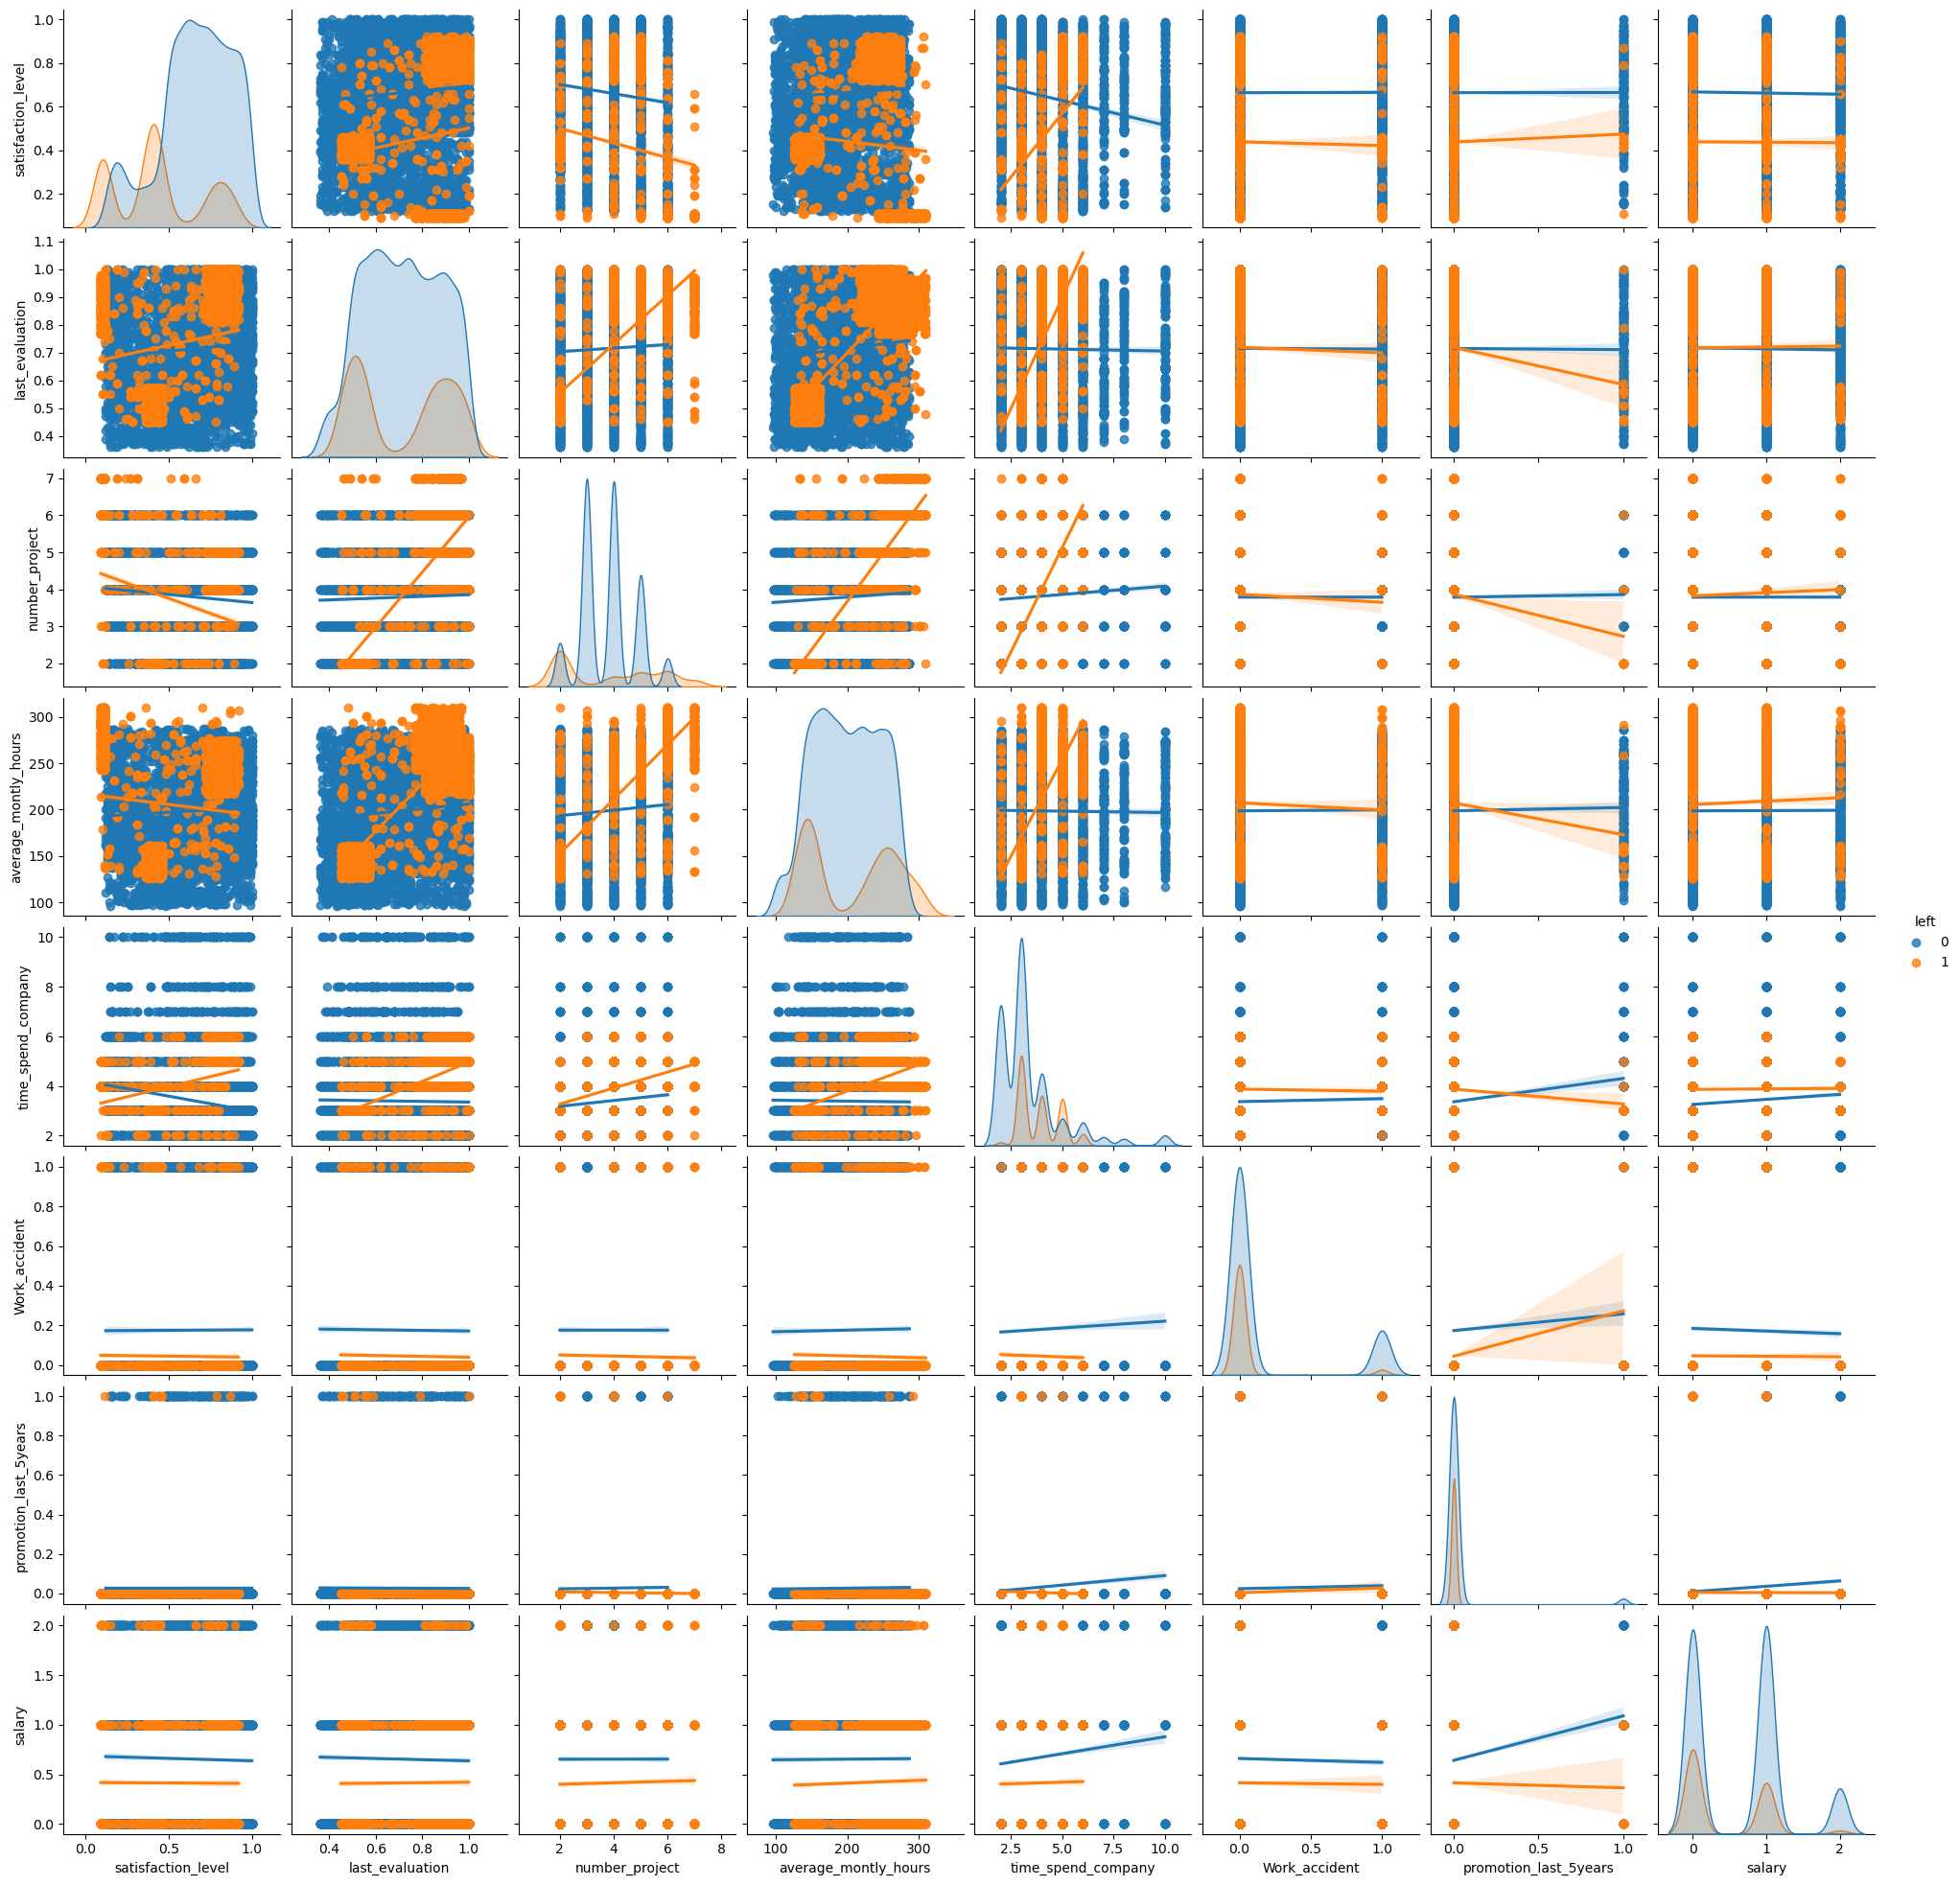

In [124]:
hr_analytic_df = hr_df[['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company','Work_accident','promotion_last_5years','salary','left']]

plt.figure(figsize=(20,10))
sns.pairplot(data=hr_analytic_df,diag_kind='kde',kind='reg',hue='left')
plt.show()

##### 從相關係數及pairplot來看，我們認為最重要的兩種特徵是：
- 滿意度 (satisfaction_level)
- 薪水 (salary)

> 如何找出特徵之重要性？ A: 從相關係數來看資料之間的趨勢以及從 pairplot 來看資料的大致分佈

##### 我們嘗試創造更相關的特徵以提升準確度，根據對此資料的主觀想法，我們認為：

- 每小時的薪水可能更有參考價值
- 對公司的喜愛程度 -> 或許可以從待在公司的工作時間得知 因此我們把在公司待的時間 與每個月平均工作時間 scale到同一區間 在做差異得到此特徵

In [125]:
hr_analytic_df['salary_per_hour'] = (hr_analytic_df['salary']*100+100) / hr_analytic_df['average_montly_hours'] 
#喜歡公司的程度
hr_analytic_df['job satisificaton'] = (hr_analytic_df['time_spend_company'] * 27+42) - hr_analytic_df['average_montly_hours']
hr_analytic_df.head()

C:\Users\Terry\AppData\Local\Temp\ipykernel_33380\3612964517.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hr_analytic_df['salary_per_hour'] = (hr_analytic_df['salary']*100+100) / hr_analytic_df['average_montly_hours']
C:\Users\Terry\AppData\Local\Temp\ipykernel_33380\3612964517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hr_analytic_df['job satisificaton'] = (hr_analytic_df['time_spend_company'] * 27+42) - hr_analytic_df['average_montly_hours']


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,left,salary_per_hour,job satisificaton
0,0.41,0.50,2,153,3,0,0,0.0,1,0.653595,-30
1,0.92,0.85,5,259,5,0,0,0.0,1,0.386100,-82
2,0.89,1.00,5,224,5,0,0,0.0,1,0.446429,-47
3,0.45,0.54,2,135,3,0,0,0.0,1,0.740741,-12
4,0.84,0.92,4,234,5,0,0,0.0,1,0.427350,-57


In [126]:
X_train = hr_analytic_df.drop(['left','salary','time_spend_company'],axis=1)
y_train = hr_analytic_df['left']


dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
train_pred = dt.predict(X_train)

print("acc:",accuracy_score(y_train,train_pred))


acc: 1.0


In [127]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaler = scaler.transform(X_train)

X_train_scaler = pd.DataFrame(X_train_scaler, columns=X_train.columns)


In [129]:
dt = DecisionTreeClassifier()

dt.fit(X_train_scaler,y_train)
train_pred = dt.predict(X_train_scaler)

print("acc:",accuracy_score(y_train,train_pred))

acc: 1.0


In [160]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np


dt = DecisionTreeClassifier()

# 進行5折交叉驗證
scores = cross_val_score(dt, X_train_scaler, y_train, cv=5)

# 輸出每一折的準確度
print("Accuracy scores for each fold:", scores)

# 計算平均準確度
print("Average cross-validation accuracy:", np.mean(scores))


Accuracy scores for each fold: [0.9785 0.9655 0.9665 0.984  0.9675]
Average cross-validation accuracy: 0.9724


In [96]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np


rg = LogisticRegression()
# 進行5折交叉驗證
scores = cross_val_score(rg, X_train_scaler, y_train, cv=5)

# 輸出每一折的準確度
print("Accuracy scores for each fold:", scores)

# 計算平均準確度
print("Average cross-validation accuracy:", np.mean(scores))


Accuracy scores for each fold: [0.802  0.804  0.808  0.8005 0.6435]
Average cross-validation accuracy: 0.7716000000000001


In [161]:
test_hr_df = pd.read_csv('HW2_hr-analytics_test.csv')

categories_order = [['low', 'medium', 'high']]
ordinal_encoder = OrdinalEncoder(categories=categories_order)
test_hr_df['salary'] = ordinal_encoder.fit_transform(test_hr_df[['salary']])


test_hr_analytic_df = test_hr_df[['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company','Work_accident','promotion_last_5years','salary']]
test_hr_analytic_df['salary_per_hour'] = (test_hr_analytic_df['salary']*100+100) / test_hr_analytic_df['average_montly_hours'] 
test_hr_analytic_df['job satisificaton'] = (test_hr_analytic_df['time_spend_company'] * 27+42) - test_hr_analytic_df['average_montly_hours']

test_hr_analytic_df = test_hr_analytic_df.drop(['salary','time_spend_company'],axis=1)


In [162]:
test_hr_analytic_df = scaler.transform(test_hr_analytic_df)

dt.fit(X_train_scaler,y_train)
hr_pred = dt.predict(test_hr_analytic_df)

hr_pred = pd.DataFrame({"left":hr_pred})
hr_pred.to_csv('HW2_hr-analytics_test_sol.csv',index=False)

d:\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


### 探討 Logistic Regression 與 Decision Tree 的預測準確率

- 以下分別是 Logistic Regression 以及 Decision Tree 經過 cross validation 的平均準確率 (Accuracy) 比較 

    |        |Logist Regression|Decision Tree|
    |--------|-----------------|-------------|
    |Accuracy|     0.7716      |    0.9705   |



- 由結果來看： Decision Tree 模型較適合
- 可能原因：Logistic regression 僅僅只有 乘上權重加上bias 再通過 sigmoid 函數，這樣的架構可能不足以完美去 fit 一個判斷是否離職的函數，因為離職牽扯的因素很多，包含薪水、工作滿意度、工作風險...等， 而 Decision Tree 較適合的原因可能為 每一個節點都可以一分為二 ，因此一個決策樹有許多個節點就意味著他考慮許多種情況，如此以來，比較能 fit 離職這樣複雜的情況，但同時也要小心決策樹容易 overfit 訓練集的資料

### （二）針對信用卡交易資料，預測是否為詐騙的交易

In [2]:
import pandas as pd

credit_df = pd.read_csv('HW3_creditcard.csv')

credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28924 entries, 0 to 28923
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    28924 non-null  int64  
 1   V1      28924 non-null  float64
 2   V2      28924 non-null  float64
 3   V3      28924 non-null  float64
 4   V4      28924 non-null  float64
 5   V5      28924 non-null  float64
 6   V6      28924 non-null  float64
 7   V7      28924 non-null  float64
 8   V8      28924 non-null  float64
 9   V9      28924 non-null  float64
 10  V10     28924 non-null  float64
 11  V11     28924 non-null  float64
 12  V12     28924 non-null  float64
 13  V13     28924 non-null  float64
 14  V14     28924 non-null  float64
 15  V15     28924 non-null  float64
 16  V16     28924 non-null  float64
 17  V17     28924 non-null  float64
 18  V18     28924 non-null  float64
 19  V19     28924 non-null  float64
 20  V20     28924 non-null  float64
 21  V21     28924 non-null  float64
 22

In [3]:
from sklearn.model_selection import train_test_split

X = credit_df.drop('Class', axis=1)
y = credit_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)



In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

dt2 = DecisionTreeClassifier()

dt2.fit(X_train, y_train)
credit_pred = dt2.predict(X_test)


credit_prob = dt2.predict_proba(X_test)[:,1]

print("Accuracy:",accuracy_score(y_test,credit_pred))
print("Precision:",precision_score(y_test,credit_pred))
print("Recall:",recall_score(y_test,credit_pred))
print("F1-score:",f1_score(y_test,credit_pred))
print("AUROC:",roc_auc_score(y_test,credit_prob))



Accuracy: 0.9935469002074211
Precision: 0.7948717948717948
Recall: 0.8378378378378378
F1-score: 0.8157894736842105
AUROC: 0.9170431862108297


##### 統計類別間的數量 發現數據不平衡： 詐騙的資料數 比 不是詐騙的資料數目 少很多

In [10]:
print(credit_df.Class.value_counts())
# print(y_train.value_counts())
# print(y_test.value_counts())

0    28432
1      492
Name: Class, dtype: int64


##### 為了提高recall數值：

- 改變decision tree 的類別權重

In [112]:
from sklearn.metrics import classification_report

dt2_weighted = DecisionTreeClassifier(class_weight='balanced')

dt2_weighted.fit(X_train, y_train)

credit_weighted_pred = dt2_weighted.predict(X_test)
credit_weighted_prob = dt2_weighted.predict_proba(X_test)[:,1]

# print(classification_report(y_test, credit_weighted_pred))

print("Accuracy:",accuracy_score(y_test,credit_weighted_pred))
print("Precision:",precision_score(y_test,credit_weighted_pred))
print("Recall:",recall_score(y_test,credit_weighted_pred))
print("F1-score:",f1_score(y_test,credit_weighted_pred))
print("AUROC:",roc_auc_score(y_test,credit_weighted_prob))

Accuracy: 0.9932011984328186
Precision: 0.7986577181208053
Recall: 0.8040540540540541
F1-score: 0.8013468013468014
AUROC: 0.9002685276131933


- 利用imbalanced-learn 套件中 SMOTE 來增量資料

In [114]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print(Counter(y_train_smote))

dt2 = DecisionTreeClassifier()

dt2.fit(X_train_smote, y_train_smote)
credit_smote_pred = dt2.predict(X_test)
credit_smote_prob = dt2.predict_proba(X_test)[:,1]

# print(classification_report(y_test, credit_smote_pred))

print("Accuracy:",accuracy_score(y_test,credit_smote_pred))
print("Precision:",precision_score(y_test,credit_smote_pred))
print("Recall:",recall_score(y_test,credit_smote_pred))
print("F1-score:",f1_score(y_test,credit_smote_pred))
print("AUROC:",roc_auc_score(y_test,credit_smote_prob))

Accuracy: 0.9870938004148422
Precision: 0.5818181818181818
Recall: 0.8648648648648649
F1-score: 0.6956521739130435
AUROC: 0.9270397008966763


##### 改用 XGBoost 模型

In [117]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(X_train_smote, y_train_smote)
xgb_pred = xgb.predict(X_test)
xgb_prob = xgb.predict_proba(X_test)[:,1]

# print(classification_report(y_test, xgb_pred))

print("Accuracy:",accuracy_score(y_test,xgb_pred))
print("Precision:",precision_score(y_test,xgb_pred))
print("Recall:",recall_score(y_test,xgb_pred))
print("F1-score:",f1_score(y_test,xgb_pred))
print("AUROC:",roc_auc_score(y_test,xgb_prob))

Accuracy: 0.9958515787047707
Precision: 0.9057971014492754
Recall: 0.8445945945945946
F1-score: 0.8741258741258742
AUROC: 0.9850357244700738
